In [11]:
from pandas_datareader import data 
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import datetime as dt
import urllib.request, json
import os
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [12]:
data_source = 'na'  # Change to 'yahoo' for Yahoo Finance data
os.environ["no_proxy"] = "*"
if data_source == 'alphavantage':
    # Alpha Vantage API key
    with open('api_key.txt') as f:
        api_key = f.read().strip()
    # Define the stock symbol and the time period
    symbol = 'AAL'
    url_string = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&outputsize=full&apikey={api_key}&datatype=json'
    file_destination = f'{symbol}.json'

    if not os.path.exists(file_destination):
        # Download the data
        with urllib.request.urlopen(url_string) as url:
            data = json.loads(url.read().decode())
            #print columns(data)
            print(data)
            data = data['Time Series (Daily)']
            df = pd.DataFrame(columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
            for date, values in data.items():
                date = dt.datetime.strptime(date, '%Y-%m-%d')
                row = [date.date(), float(values['1. open']), float(values['2. high']), float(values['3. low']), float(values['4. close']), int(values['5. volume'])]
                df.loc[-1,:] = row
                df.index = df.index + 1
        df.to_csv(file_destination)
    else:
        df = pd.read_csv(file_destination)
else:
    path = os.path.join("stocks/Stocks","hpq.us.txt")
    df = pd.read_csv(path, delimiter=',', usecols= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])


                

In [13]:
df=df.sort_values('Date')
df.head()  

,Date,Open,High,Low,Close,Volume
0,1970-01-02,0.30627,0.30627,0.30627,0.30627,2441124
1,1970-01-05,0.30627,0.31768,0.30627,0.31385,6219848
2,1970-01-06,0.31385,0.31385,0.30996,0.30996,4447522
3,1970-01-07,0.31385,0.31385,0.31385,0.31385,1872638
4,1970-01-08,0.31385,0.31768,0.31385,0.31385,4280330


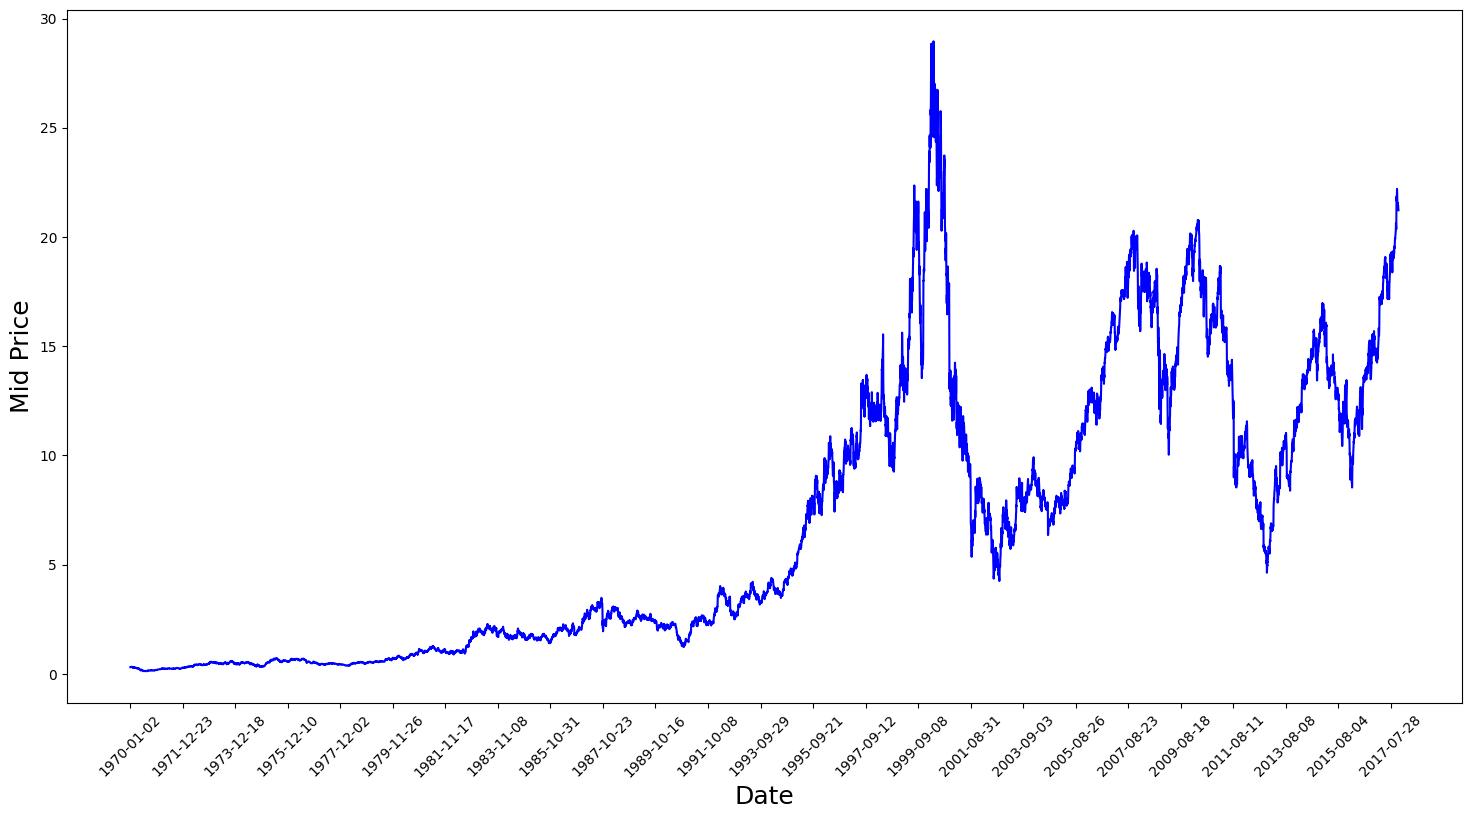

In [14]:
plt.figure(figsize=(18,9))
plt.plot(range(df.shape[0]), (df['Low']+df['High'])/2, color='blue' )
plt.xticks(range(0, df.shape[0], 500), df['Date'].loc[::500], rotation=45)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Mid Price', fontsize=18)
plt.show()

In [15]:
high_prices = df.loc[:,'High'].to_numpy()
low_prices = df.loc[:,'Low'].to_numpy()
mid_prices = (high_prices+low_prices)/2.0

In [16]:
mid_prices

array([ 0.30627 ,  0.311975,  0.311905, ..., 21.355   , 21.275   ,
       21.225   ])

(9660, 1)


MSE error for standard averaging: 0.00368


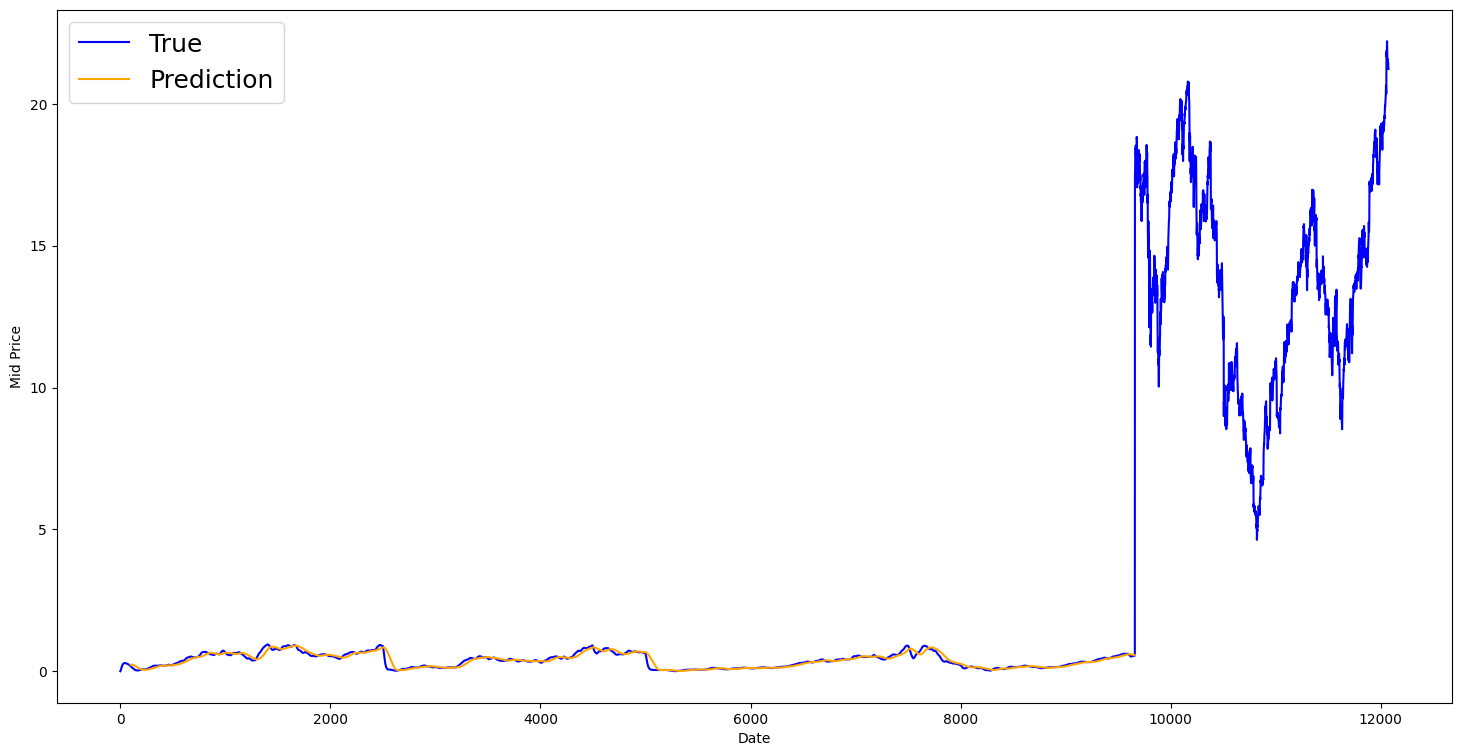

In [ ]:
OLD CODE. DOESNT WORK




training_data = mid_prices[:int(len(mid_prices)*0.8)]
test_data = mid_prices[int(len(mid_prices)*0.8):]
scaler = MinMaxScaler()
training_data = training_data.reshape(-1, 1)
test_data = test_data.reshape(-1, 1)

smoothing_window = 2500
n = training_data.shape[0]
for start in range(0, n, smoothing_window):
    end = min(start + smoothing_window, n)
    scaler.fit(training_data[start:end, :])
    training_data[start:end, :] = scaler.transform(training_data[start:end, :])
print(training_data.shape)

training_data = training_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)
EMA = 0.0
gamma = 0.1
for ti in range(9660):
  EMA = gamma*training_data[ti] + (1-gamma)*EMA
  training_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([training_data,test_data],axis=0)
window_size = 100
N = training_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(training_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-training_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()


